# Постановка задачи:

Необходимо провести анализ данных истории торгов, сформировать отчёт на основании этих данных. На гитхабе задача сформулирована следующим образом: "1. Хотел бы написать скрипт на пайтоне - создание модели. Поработать со статистикой торговли с биржи. анализ полученного датасета, сбор данных ><"

Решение задачи бинарной классификации. Данные разделены на два класса, необходимо обучить модель определять принадлежность произвольного объекта (из рассматриваемого множества) к одному из них. На выходе алгоритм должен выдавать либо метку одного из двух классов, либо вероятности принадлежности рассматриваемого объекта к каждому из них. Целевая переменная - тип сделки. `BUY` или `SELL`

Решить с помощью 
- линейной регрессии 
- деревьев решений

### Метрики качества
- Confusion matrix (матрица ошибок)
- Accuracy (доля правильных ответов)
- Precision (точность) & Recall (полнота)
- F-score (F-мера, гармоническое среднее)
- PR-кривая
- ROC-кривая

# Датасет:

Датасет скачивается с сайта EXMO.ME. В профиле есть возможность скачать историю торгов в формате __.csv__. Это будет являться исходным датасетом, с которым предстоит работать. 

#### Описание датасета:

10 столбцов, 9800 строк

1. Дата/время  - __время когда произошла сделка__

2. Trade ID - __идентификационный номер сделки__

3. Тип - __тип сделки. всего 2 типа сделок: продажа и покупка__

4. Валютная пара  - __название валютной пары в которой произошла сделка. На бирже около 130 валютных пар__

5. Количество - __количество купленной или проданной валюты__

6. Цена - __цена по которой произошла сделка__

7. Сумма - __общая сумма сделки__

8. Тип комиссии - __2 типа комиссий: maker, taker__

9. Размер комиссии - __общая сумма коммиссии за сделку__

10. Комиссия % - __процентная ставка комиссии__ 

# Загрузка данных:

создаю переменную - объект в которую считываю скаченный с сайта файл __.csv__, который предварительно поместил в ту же папку, в которой создал юпитерноутбук. Переменная является датафреймом.

In [2]:
df = pd.read_csv('trade-history-2023-02-08.csv')
df

,Дата/время,Trade ID,Тип,Валютная пара,Количество,Цена,Сумма,Тип комиссии,Размер комиссии,Комиссия %
0,08.02.2023 16:44,455142695,buy,ROOBEE_USDT,1916.666667,0.001200,2.300000,maker,1.916667,0.1%
1,08.02.2023 16:30,455139957,buy,ROOBEE_USDT,1561.538462,0.001300,2.030000,maker,1.561538,0.1%
2,08.02.2023 05:00,455021596,sell,XTZ_RUB,2.015574,90.000000,181.401646,maker,0.544205,0.3%
3,08.02.2023 05:00,455021556,sell,XTZ_RUB,1.340000,89.000000,119.260000,maker,0.357780,0.3%
4,07.02.2023 22:47,454961186,sell,WXT_USDT,3247.579434,0.005000,16.237897,maker,0.016238,0.1%
...,...,...,...,...,...,...,...,...,...,...
10000,27.10.2021 11:54,324915052,buy,BTT_RUB,284.542819,0.250000,71.135705,maker,0.853628,0.3%
10001,27.10.2021 11:54,324915049,buy,BTT_RUB,314.485477,0.248200,78.055229,taker,0.943456,0.3%
10002,27.10.2021 11:54,324915048,buy,BTT_RUB,315.695899,0.247581,78.160256,taker,0.947088,0.3%
10003,27.10.2021 11:54,324915047,buy,BTT_RUB,480.608526,0.247581,118.989453,taker,1.441826,0.3%


# Установка библиотек и модулей:

In [51]:
! pip install pandas

In [52]:
! pip install numpy

In [53]:
! pip install seaborn

In [55]:
! pip install matplotlib

# Загрузка библиотек и модулей:

In [43]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
        
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
# from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Функции для более быстрой и удобной работы с датасетом:
#####  Объединение датасетов
Так как скаченная с сайта история торгов содержит всего 10000 значений, то возникает необходимость для создания полной картины по торгам объединить 2 датасета с более ранней историей торгов и с последней скаченной истории торгов. Тогда получится максимальное значение строк и более полная история торгов. Причём надо будет избавиться от дубликатов данных, которые могут оказаться в двух таблицах и после объединения продублируются.

In [2]:
def big_dataset(dataframe_first, dataframe_last):
    
    big_df = pd.concat([dataframe_first, dataframe_last], ignore_index=True)
    big_df_uniq = big_df.drop_duplicates()
    return big_df_uniq

In [4]:
df_first = pd.read_csv('trade-history-2021-11-07.csv')
df_middle = pd.read_csv('trade-history-2023-01-21.csv')
df_last = pd.read_csv('trade-history-2023-05-06.csv')

big_df_1 = pd.concat([df_middle, df_first], ignore_index=True).drop_duplicates()
print(len(df_first), len(df_middle), len(big_df_1))

big_df = pd.concat([df_last, big_df_1], ignore_index=True).drop_duplicates()
print(len(df_first), len(big_df_1), len(big_df))


9764 10004 19087
9764 19087 20191


##### Определение даты  самой ранней сделки и самой последней сделки. Подсчёт временного периода торговли

In [5]:
def time_period(dataframe):
    all_dates = dataframe['Дата/время'].tolist()
    start = all_dates[-1]
    end = all_dates[0]
    start_dtm = datetime.datetime.strptime(start, '%d.%m.%Y %H:%M')
    end_dtm = datetime.datetime.strptime(end, '%d.%m.%Y %H:%M')
    print(f'\nПроизведён анализ временного периода торговли: с {start} по {end}'
        

  f'\nчто составляет {end_dtm - start_dtm}')
    

In [6]:
time_period(big_df)


Произведён анализ временного периода торговли: с 14.04.2021 06:57 по 06.05.2023 08:34
что составляет 752 days, 1:37:00


##### Переформатирование колонки время сделки в дататайм

In [7]:
def to_datetime(dataframe):
    dataframe['Дата/время'] = pd.to_datetime(dataframe['Дата/время'], format='%d.%m.%Y %H:%M')
    return dataframe

In [8]:
big_df['Дата/время'].dtype


dtype('O')

##### Проверка при объединении датасетов на дубликаты

In [9]:
def duplicates(dataframe_first, dataframe_last):
    big_df = pd.concat([dataframe_first, dataframe_last], ignore_index=True).drop_duplicates()
    if len(big_df) == len(dataframe_first) + len(dataframe_last):
        print('Полное объединение датасетов. Дубликатов нет.\n'
              'Следует проверить последние и первые даты в датасетах\n'
              'возможно есть промежуточный датасет ')
    else:
        print('Объединение датасетов произошло. Число дубликатов:', len(dataframe_first) + len(dataframe_last) - len(big_df))
        

In [11]:
duplicates(df_first, big_df_1)

Объединение датасетов произошло. Число дубликатов: 9764


##### Вывод названий всех торговых пар в которых велась торговля и показывает число сделок в каждой торговой паре

In [12]:
def all_pairs_count(dataframe):
    df_all_pairs = dataframe['Валютная пара'].value_counts()
    return df_all_pairs

In [13]:
all_pairs_count(big_df)

EXM_RUB      2447
USDT_GBP     2118
WXT_USDT     1442
SMART_EUR    1301
EXM_BTC      1251
             ... 
BTC_USDX        1
ONT_BTC         1
VITAE_BTC       1
ALGO_BTC        1
BTC_RUB         1
Name: Валютная пара, Length: 63, dtype: int64

In [14]:
all_pairs_count(big_df)

EXM_RUB      2447
USDT_GBP     2118
WXT_USDT     1442
SMART_EUR    1301
EXM_BTC      1251
             ... 
BTC_USDX        1
ONT_BTC         1
VITAE_BTC       1
ALGO_BTC        1
BTC_RUB         1
Name: Валютная пара, Length: 63, dtype: int64

##### Функция возвращает список всех торговых пар

In [15]:
def all_pairs_list(dataframe):
    pairs_list = dataframe['Валютная пара'].unique().tolist()
    return pairs_list

In [16]:
all_pairs_list(big_df)

['EXM_BTC',
 'EXM_ETH',
 'XRP_ETH',
 'XTZ_RUB',
 'DOGE_RUB',
 'DOGE_BTC',
 'WXT_BTC',
 'TON_BTC',
 'DAI_RUB',
 'WXT_USDT',
 'DOGE_USDT',
 'XLM_RUB',
 'PRQ_USDT',
 'ROOBEE_USDT',
 'DAI_ETH',
 'SHIB_RUB',
 'EXM_USDT',
 'CRON_ETH',
 'CRON_BTC',
 'CHZ_BTC',
 'USDT_KZT',
 'USDT_RUB',
 'DOGE_EUR',
 'USDT_EUR',
 'ROOBEE_BTC',
 'ETH_GBP',
 'SMART_BTC',
 'DOGE_GBP',
 'SMART_EUR',
 'SMART_RUB',
 'XRP_GBP',
 'BTC_USDX',
 'XRP_RUB',
 'ALGO_BTC',
 'TRX_BTC',
 'SHIB_UAH',
 'CRON_USDT',
 'EXM_RUB',
 'TRX_UAH',
 'ALGO_RUB',
 'XRP_USD',
 'SHIB_USDT',
 'MNC_ETH',
 'TRX_RUB',
 'ETC_RUB',
 'MNC_BTC',
 'USDT_UAH',
 'HB_BTC',
 'USDT_GBP',
 'TONCOIN_BTC',
 'HP_BTC',
 'BTT_RUB',
 'BTT_BTC',
 'SMART_USD',
 'VITAE_BTC',
 'VITAE_ETH',
 'XRP_UAH',
 'XRP_EUR',
 'ONT_BTC',
 'ONG_BTC',
 'XRP_USDT',
 'XEM_BTC',
 'BTC_RUB']

##### Выборка датасета по конкретной валютной паре

In [17]:
def df_curr_pair(dataframe, current_pair):
    current = str(current_pair.upper())
    df_curpair = dataframe.loc[(dataframe['Валютная пара'] == current)]
    return df_curpair

In [18]:
df_cur_pair = df_curr_pair(big_df, 'EXM_ETH')
df_cur_pair

,Дата/время,Trade ID,Тип,Валютная пара,Количество,Цена,Сумма,Тип комиссии,Размер комиссии,Комиссия %
1,06.05.2023 08:01,476346355,sell,EXM_ETH,0.008229,0.000007,6.000000e-08,maker,0.000000e+00,0.1%
2,06.05.2023 08:01,476346354,sell,EXM_ETH,576.058184,0.000007,4.205220e-03,maker,4.200000e-06,0.1%
3,06.05.2023 06:25,476331181,sell,EXM_ETH,53.889276,0.000007,3.880000e-04,maker,3.800000e-07,0.1%
4,06.05.2023 06:24,476331039,sell,EXM_ETH,141.208914,0.000007,1.016700e-03,maker,1.010000e-06,0.1%
5,06.05.2023 06:24,476331038,sell,EXM_ETH,141.184908,0.000007,1.016530e-03,maker,1.010000e-06,0.1%
...,...,...,...,...,...,...,...,...,...,...
26155,06.06.2021 05:31,278025748,sell,EXM_ETH,225.792700,0.000030,6.773780e-03,maker,2.032000e-05,0.3%
26376,05.06.2021 14:27,277865686,sell,EXM_ETH,92.390657,0.000020,1.847810e-03,maker,5.540000e-06,0.3%
26380,05.06.2021 14:27,277865613,sell,EXM_ETH,569.620001,0.000020,1.139240e-02,maker,3.417000e-05,0.3%
26701,26.05.2021 23:30,274981680,buy,EXM_ETH,664.002667,0.000015,9.960030e-03,maker,1.992008e+00,0.3%


##### Подсчёт  Buy и Sell ордеров в датасете

In [19]:
def buy_sell_count(dataframe):
    return dataframe['Тип'].value_counts()

In [20]:
buy_sell_count(df_cur_pair)

buy     204
sell    179
Name: Тип, dtype: int64

##### Визуализация данных по Buy и Sell

In [21]:
def visual_buy_sell(dataframe):
    plt.figure(figsize=(8, 5))

    sns.countplot(x='Тип', data=dataframe)
    plt.title('Target variable distribution')
    plt.show()

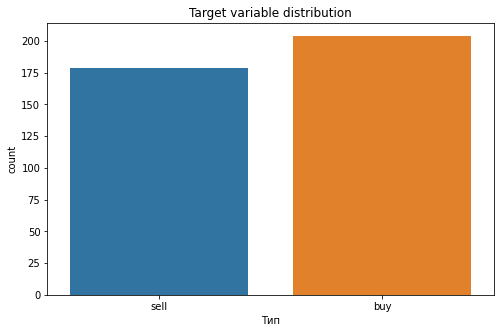

In [22]:
visual_buy_sell(df_cur_pair)

##### Проверка на дисбаланс классов

In [23]:
def dissbalance(dataframe):
    # class count
    class_count_0, class_count_1 = dataframe['Тип'].value_counts()

    # Separate class
    class_0 = dataframe[dataframe['Тип'] == 'buy']
    class_1 = dataframe[dataframe['Тип'] == 'sell']# print the shape of the class
    print('buy class 0:', class_0.shape)
    print('sell class 1:', class_1.shape)
    

In [24]:
dissbalance(big_df)

buy class 0: (10776, 10)
sell class 1: (9415, 10)


##### Изменение начального датасета, добавление демипеременных, избавление от типов object

In [25]:
def prepare_data(dataframe):
    prep_data = pd.concat([dataframe, pd.get_dummies(dataframe['Тип'])], axis=1)
    prep_data.drop(columns=['Тип'], inplace=True)
    prep_data = pd.concat([prep_data, pd.get_dummies(dataframe['Тип комиссии'])], axis=1)
    prep_data.drop(columns=['Тип комиссии'], inplace=True)
    prep_data = pd.concat([prep_data, pd.get_dummies(dataframe['Комиссия %'])], axis=1)
    prep_data.drop(columns=['Комиссия %'], inplace=True)
    prep_data.drop(columns=['Trade ID'], inplace=True)
    prepare_data = to_datetime(prep_data)
    return prepare_data

In [30]:
pr_df = prepare_data(df_cur_pair) 
pr_df

,Дата/время,Валютная пара,Количество,Цена,Сумма,Размер комиссии,days,buy,sell,maker,taker,0.1%,0.3%
1,2023-05-06 08:01:00,EXM_ETH,0.008229,0.000007,6.000000e-08,0.000000e+00,06,0,1,1,0,1,0
2,2023-05-06 08:01:00,EXM_ETH,576.058184,0.000007,4.205220e-03,4.200000e-06,06,0,1,1,0,1,0
3,2023-05-06 06:25:00,EXM_ETH,53.889276,0.000007,3.880000e-04,3.800000e-07,06,0,1,1,0,1,0
4,2023-05-06 06:24:00,EXM_ETH,141.208914,0.000007,1.016700e-03,1.010000e-06,06,0,1,1,0,1,0
5,2023-05-06 06:24:00,EXM_ETH,141.184908,0.000007,1.016530e-03,1.010000e-06,06,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26155,2021-06-06 05:31:00,EXM_ETH,225.792700,0.000030,6.773780e-03,2.032000e-05,06,0,1,1,0,0,1
26376,2021-06-05 14:27:00,EXM_ETH,92.390657,0.000020,1.847810e-03,5.540000e-06,05,0,1,1,0,0,1
26380,2021-06-05 14:27:00,EXM_ETH,569.620001,0.000020,1.139240e-02,3.417000e-05,05,0,1,1,0,0,1
26701,2021-05-26 23:30:00,EXM_ETH,664.002667,0.000015,9.960030e-03,1.992008e+00,26,1,0,1,0,0,1


##### Число сделок в день (сортировка по количеству сделок)

In [26]:
def per_day_val(dataframe):
    new_vals = []
    vals = dataframe['Дата/время'].values
    for el in vals:
        numb = el[0:2]
        new_vals.append(numb)
    dataframe['days'] = new_vals
    dataframe['days'].value_counts()
    return dataframe['days'].value_counts()

In [27]:
per_day_val(df_cur_pair)

03    30
23    27
13    22
11    20
06    19
02    19
05    18
14    17
26    16
24    16
01    15
18    15
22    14
12    14
16    12
17    12
10    11
21    10
27    10
09     8
29     7
30     7
31     6
25     6
28     6
15     6
07     6
04     5
20     4
19     4
08     1
Name: days, dtype: int64

##### Число сделок в день (сортировка по дате)

In [30]:
from collections import Counter

def per_day_date(dataframe):
    new_vals = []
    vals = dataframe['Дата/время'].values
    for el in vals:
        numb = el[0:2]
        new_vals.append(numb)
    count = Counter(new_vals)
    
    return dict(sorted(count.items()))

In [34]:
per_day_date(df_apr_2023)

{'01': 10,
 '02': 5,
 '03': 23,
 '04': 9,
 '05': 5,
 '06': 8,
 '07': 8,
 '08': 14,
 '09': 4,
 '10': 5,
 '11': 9,
 '12': 8,
 '13': 4,
 '14': 6,
 '15': 4,
 '16': 4,
 '17': 14,
 '18': 1,
 '19': 5,
 '20': 8,
 '21': 7,
 '22': 5,
 '23': 4}

### Анализ данных:

Смотрю тип данных в каждой колонке, чтобы из датафрейма сделать припарированный, новый подготовленный для аналитики датасет.

In [28]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20191 entries, 0 to 29091
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Дата/время       20191 non-null  object 
 1   Trade ID         20191 non-null  int64  
 2   Тип              20191 non-null  object 
 3   Валютная пара    20191 non-null  object 
 4   Количество       20191 non-null  float64
 5   Цена             20191 non-null  float64
 6   Сумма            20191 non-null  float64
 7   Тип комиссии     20191 non-null  object 
 8   Размер комиссии  20191 non-null  float64
 9   Комиссия %       20191 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.7+ MB


Пропуски отсутствуют. Типы данных:  float64 - 4 столбца,  int64 - 1 столбец. object - 5 столбцов. итого:  5 столбцов у нас числовые, 5 столбцов категориальные. 

Смотрю сразу же препарированные данные

In [31]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 1 to 27610
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Дата/время       383 non-null    datetime64[ns]
 1   Валютная пара    383 non-null    object        
 2   Количество       383 non-null    float64       
 3   Цена             383 non-null    float64       
 4   Сумма            383 non-null    float64       
 5   Размер комиссии  383 non-null    float64       
 6   days             383 non-null    object        
 7   buy              383 non-null    uint8         
 8   sell             383 non-null    uint8         
 9   maker            383 non-null    uint8         
 10  taker            383 non-null    uint8         
 11  0.1%             383 non-null    uint8         
 12  0.3%             383 non-null    uint8         
dtypes: datetime64[ns](1), float64(4), object(2), uint8(6)
memory usage: 26.2+ KB


### Обзор количественных переменных:
Количественные (непрерывные) переменные - это переменные, которые могут принимать любые числовые значения в некотором диапазоне.

In [32]:
df_num_features = big_df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Trade ID,Количество,Цена,Сумма,Размер комиссии
0,476351943,64.793009,4.900000e-07,3.174000e-05,3.000000e-08
1,476346355,0.008229,7.300000e-06,6.000000e-08,0.000000e+00
2,476346354,576.058184,7.300000e-06,4.205220e-03,4.200000e-06
3,476331181,53.889276,7.200000e-06,3.880000e-04,3.800000e-07
4,476331039,141.208914,7.200000e-06,1.016700e-03,1.010000e-06


С помощью .describe можно получить первичное понимание того, что из себя представляют данные

In [33]:
df_num_features.describe()

,Trade ID,Количество,Цена,Сумма,Размер комиссии
count,2.019100e+04,2.019100e+04,2.019100e+04,2.019100e+04,20191.000000
mean,3.390256e+08,1.878377e+04,2.312927e+02,1.477147e+02,29.082879
std,5.833004e+07,2.157841e+05,2.869231e+04,5.855574e+02,415.977626
min,2.574128e+08,1.000000e-08,1.000000e-08,1.000000e-08,0.000000
25%,2.867217e+08,2.220000e+00,3.400000e-04,1.419140e-03,0.002428
50%,3.314558e+08,1.600000e+01,6.000000e-02,1.492303e+00,0.020473
75%,3.763665e+08,3.141987e+02,1.175000e+00,7.500000e+01,0.340965
max,4.763519e+08,1.200000e+07,4.076950e+06,2.200000e+04,24000.001200


### Обзор номинативных переменных
Номинативная (категориальная) переменная - тип дискретной переменной, качественная (неколичественная) переменная величина

In [34]:
df_num_features = big_df.select_dtypes(include=['object'])
df_num_features.head()

,Дата/время,Тип,Валютная пара,Тип комиссии,Комиссия %
0,06.05.2023 08:34,sell,EXM_BTC,maker,0.1%
1,06.05.2023 08:01,sell,EXM_ETH,maker,0.1%
2,06.05.2023 08:01,sell,EXM_ETH,maker,0.1%
3,06.05.2023 06:25,sell,EXM_ETH,maker,0.1%
4,06.05.2023 06:24,sell,EXM_ETH,maker,0.1%


Подсчёты количества значений

In [35]:
big_df['Тип'].value_counts()

buy     10776
sell     9415
Name: Тип, dtype: int64

In [22]:
big_df[['Тип', 'Тип комиссии']].value_counts()

Тип   Тип комиссии
buy   maker           9267
sell  maker           8447
buy   taker            933
sell  taker            440
dtype: int64

In [36]:
big_df[['Дата/время', 'Тип', 'Тип комиссии', 'Валютная пара', 'Комиссия %']].nunique()

Дата/время       12347
Тип                  2
Тип комиссии         2
Валютная пара       63
Комиссия %           7
dtype: int64

### Смотрим пропуски

In [24]:
big_df.isna()

,Дата/время,Trade ID,Тип,Валютная пара,Количество,Цена,Сумма,Тип комиссии,Размер комиссии,Комиссия %
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
19763,False,False,False,False,False,False,False,False,False,False
19764,False,False,False,False,False,False,False,False,False,False
19765,False,False,False,False,False,False,False,False,False,False
19766,False,False,False,False,False,False,False,False,False,False


In [25]:
big_df.isna().sum()

Дата/время         0
Trade ID           0
Тип                0
Валютная пара      0
Количество         0
Цена               0
Сумма              0
Тип комиссии       0
Размер комиссии    0
Комиссия %         0
dtype: int64

Пропусков значений нет

# Подготовка данных, форматирование столбцов: 

Тип данных object можно по возможности переводить в иные форматы, для того чтобы с датасетом можно было поработать через дополнительные алгоритмы. У нас имеется 5 таких столбцов. 

In [40]:
prep_data = prepare_data(big_df)
prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19228 entries, 0 to 19767
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Дата/время       19228 non-null  datetime64[ns]
 1   Валютная пара    19228 non-null  object        
 2   Количество       19228 non-null  float64       
 3   Цена             19228 non-null  float64       
 4   Сумма            19228 non-null  float64       
 5   Размер комиссии  19228 non-null  float64       
 6   buy              19228 non-null  uint8         
 7   sell             19228 non-null  uint8         
 8   maker            19228 non-null  uint8         
 9   taker            19228 non-null  uint8         
 10  0%               19228 non-null  uint8         
 11  0.066666%        19228 non-null  uint8         
 12  0.093333%        19228 non-null  uint8         
 13  0.1%             19228 non-null  uint8         
 14  0.2%             19228 non-null  uint8

использовав свою написанную функцию избавляемся от 4 ёх стобцов класса Object и получаем новый датасет, с изменёнными типами столбцов более удобный для дальнейшего машинного анализа

Создадим вспомогательный признак typecomission и заполним его 0, если "Тип комиссии" maker  и 1, когда "Тип комиссии" taker

In [24]:
big_df['typecomission'] = 0
big_df.loc[big_df['Тип комиссии'] == 'taker', 'typecomission'] = 1

Создание демипеременных

In [25]:
pd.get_dummies(data=big_df.Тип, prefix='dtype').tail()

,dtype_buy,dtype_sell
19763,1,0
19764,1,0
19765,1,0
19766,1,0
19767,1,0


In [26]:
big_df = pd.concat([big_df, pd.get_dummies(big_df['Тип'])], axis=1)


удаление колонок

In [30]:
big_df.columns

Index(['Дата/время', 'Trade ID', 'Тип', 'Валютная пара', 'Количество', 'Цена',
       'Сумма', 'Тип комиссии', 'Размер комиссии', 'Комиссия %',
       'typecomission', 'buy', 'sell'],
      dtype='object')

In [31]:
big_df.drop(columns=['Trade ID', 'Тип комиссии'], inplace=True)

# Создание новых таблиц:

##### сортировка по годам

In [37]:
df_2021 = big_df[big_df['Дата/время'].str.contains("2021")]
df_2022 = big_df[big_df['Дата/время'].str.contains("2022")]
df_2023 = big_df[big_df['Дата/время'].str.contains("2023")]

##### сортировка по месяцам

In [38]:
df_jan_2021 = df_2021[df_2021['Дата/время'].str.contains(".01.2021")]
df_feb_2021 = df_2021[df_2021['Дата/время'].str.contains(".02.2021")]
df_mar_2021 = df_2021[df_2021['Дата/время'].str.contains(".03.2021")]
df_apr_2021 = df_2021[df_2021['Дата/время'].str.contains(".04.2021")]
df_may_2021 = df_2021[df_2021['Дата/время'].str.contains(".05.2021")]
df_jun_2021 = df_2021[df_2021['Дата/время'].str.contains(".06.2021")]
df_jul_2021 = df_2021[df_2021['Дата/время'].str.contains(".07.2021")]
df_avg_2021 = df_2021[df_2021['Дата/время'].str.contains(".08.2021")]
df_sep_2021 = df_2021[df_2021['Дата/время'].str.contains(".09.2021")]
df_oct_2021 = df_2021[df_2021['Дата/время'].str.contains(".10.2021")]
df_nov_2021 = df_2021[df_2021['Дата/время'].str.contains(".11.2021")]
df_dec_2021 = df_2021[df_2021['Дата/время'].str.contains(".12.2021")]

df_jan_2022 = df_2022[df_2022['Дата/время'].str.contains(".01.2022")]
df_feb_2022 = df_2022[df_2022['Дата/время'].str.contains(".02.2022")]
df_mar_2022 = df_2022[df_2022['Дата/время'].str.contains(".03.2022")]
df_apr_2022 = df_2022[df_2022['Дата/время'].str.contains(".04.2022")]
df_may_2022 = df_2022[df_2022['Дата/время'].str.contains(".05.2022")]
df_jun_2022 = df_2022[df_2022['Дата/время'].str.contains(".06.2022")]
df_jul_2022 = df_2022[df_2022['Дата/время'].str.contains(".07.2022")]
df_avg_2022 = df_2022[df_2022['Дата/время'].str.contains(".08.2022")]
df_sep_2022 = df_2022[df_2022['Дата/время'].str.contains(".09.2022")]
df_oct_2022= df_2022[df_2022['Дата/время'].str.contains(".10.2022")]
df_nov_2022 = df_2022[df_2022['Дата/время'].str.contains(".11.2022")]
df_dec_2022 = df_2022[df_2022['Дата/время'].str.contains(".12.2022")]

df_jan_2023 = df_2023[df_2023['Дата/время'].str.contains(".01.2023")]
df_feb_2023 = df_2023[df_2023['Дата/время'].str.contains(".02.2023")]
df_mar_2023 = df_2023[df_2023['Дата/время'].str.contains(".03.2023")]
df_apr_2023 = df_2023[df_2023['Дата/время'].str.contains(".04.2023")]
df_may_2023 = df_2023[df_2023['Дата/время'].str.contains(".05.2023")]
df_jun_2023 = df_2023[df_2023['Дата/время'].str.contains(".06.2023")]
df_jul_2023 = df_2023[df_2023['Дата/время'].str.contains(".07.2023")]
df_avg_2023 = df_2023[df_2023['Дата/время'].str.contains(".08.2023")]
df_sep_2023 = df_2023[df_2023['Дата/время'].str.contains(".09.2023")]
df_oct_2023 = df_2023[df_2023['Дата/время'].str.contains(".10.2023")]
df_nov_2023 = df_2021[df_2021['Дата/время'].str.contains(".11.2023")]
df_dec_2023 = df_2023[df_2023['Дата/время'].str.contains(".12.2023")]



In [39]:
def prepare_data(dataframe):
    prep_data = pd.concat([dataframe, pd.get_dummies(dataframe['Тип комиссии'])], axis=1)
    prep_data.drop(columns=['Тип комиссии'], inplace=True)
    prep_data = pd.concat([prep_data, pd.get_dummies(dataframe['Комиссия %'])], axis=1)
    prep_data.drop(columns=['Комиссия %'], inplace=True)
    prep_data.drop(columns=['Trade ID'], inplace=True)
    prepare_data = to_datetime(prep_data)
    return prepare_data

pr_df = prepare_data(big_df)

# Опрделяем целевую переменную. 
целевая переменная признак -`'Тип'`. У нас 2 возможных типа Buy и Sell.
Убираем колонку целевой признак 'Тип'и сохроняем список всех оставшихся признаков в переменную base_feature_names

In [40]:
target_name = 'Тип'
base_feature_names = pr_df.columns.drop(target_name).tolist()
new_feature_names = pr_df.columns.drop([target_name] + base_feature_names)

In [183]:
pr_df[target_name].value_counts()

buy     10270
sell     8958
Name: Тип, dtype: int64

##### Обзор распределения
мы видим что данные достаточно сбалансированны. у нас 10270 buy и 8958 sell.

отрисовка распределения целевой переменной для наглядности. 

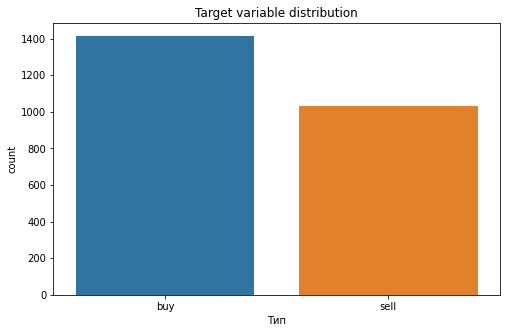

In [184]:
visual_buy_sell(df_trx_rub)

### Корреляция с базовыми признаками

Gосмотрим как будут влиять (коллерировать) неосновные признаки с основным. Мы видим у нас наблюдается положительная корреляция (> 0). Сильнее всего корреляция выражена у признака `'Сумма'`. Признак `'maker'` коррелирует меньше.
по счёту корреляции с целевым признаком практически не показывают  `'количество'`и `'Размер комиссии'`. 
Положительная корреляция у 5 признаков. Остальные 7 признаков с отрицательной корреляцией. Самая большая отрицательная корреляция у признака сумма кредита `'0.1%'`. Можем выявить группу признаков, которые коррелируют с целевой переменной. Скорее всего они будут наиболее значимыми.

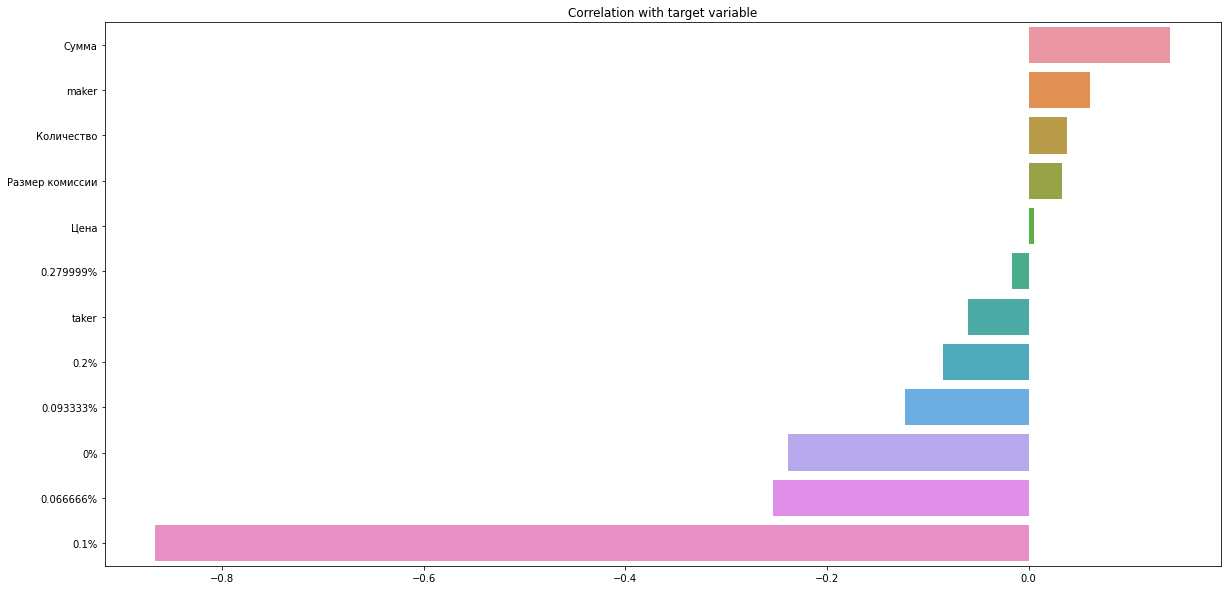

In [41]:
corr_with_target = pr_df[base_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)
                                                   
plt.figure(figsize=(20, 10))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Оценка признака "maker" в разрезе целевой переменной

Рассмотрим не сильно коррелирующий с целевой переменной признак. Признак с положительной корреляцией "maker". Построим гистанраммы распределения по которой отложем категории этого признака и количество сделок первого и нулевого класса. (вторые 2 столба самые большие) -2 соответствует категории погашен полностью, 0 соответствует категори у которой платёж погашен частично. Мы видим что соотношение клиентов класса 0 и класса 1 для этого признака PAY_1 близки к распределению целевой переменной. Поэтому можно предположить, что эти призаки можно объединить в одну категорию. Но чтобы это было обоснованное объединение нужно это как то подтвердить. Один из вариантов как это подтвердить - провести статистический тест. т.к мы сравниваем частоты, у нас будут сравнения наблюдаемых, ожидаемых и формулируем нулевую гипотезу. Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы. PAY_1 категориальная переменная. т.е мы смотрим карреляция между категориальным признаком , поэтому критерий используем Критерий: Хи-квадрат Пирсона. т.к не важно в какую сторону отклонение. Критическая область: двухсторонняя.

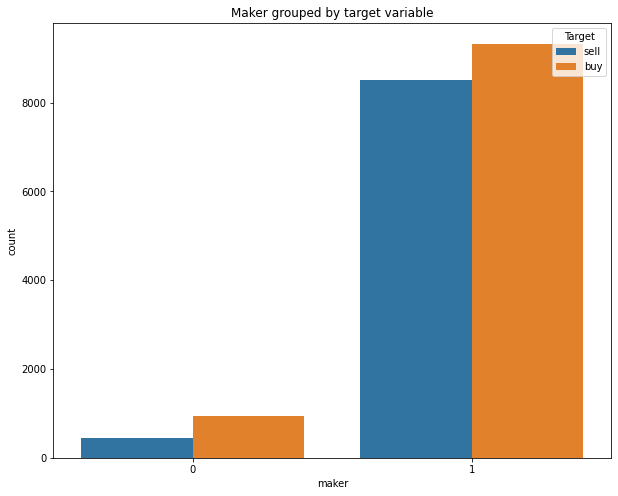

In [187]:
plt.figure(figsize=(10, 8))

sns.countplot(x='maker', hue=target_name, data=pr_df)
plt.title('Maker grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [149]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19228 entries, 0 to 19767
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Дата/время       19228 non-null  datetime64[ns]
 1   Тип              19228 non-null  object        
 2   Валютная пара    19228 non-null  object        
 3   Количество       19228 non-null  float64       
 4   Цена             19228 non-null  float64       
 5   Сумма            19228 non-null  float64       
 6   Размер комиссии  19228 non-null  float64       
 7   maker            19228 non-null  uint8         
 8   taker            19228 non-null  uint8         
 9   0%               19228 non-null  uint8         
 10  0.066666%        19228 non-null  uint8         
 11  0.093333%        19228 non-null  uint8         
 12  0.1%             19228 non-null  uint8         
 13  0.2%             19228 non-null  uint8         
 14  0.279999%        19228 non-null  uint8

### Оценка признаков "Количество", "Цена", "Сумма" в разрезе целевой переменной

посмотрим на числовой признак сумма предоставленного кредита "Количество", "Цена", "Сумма".
Также генерируем подвыборку размером 1000 сделок.

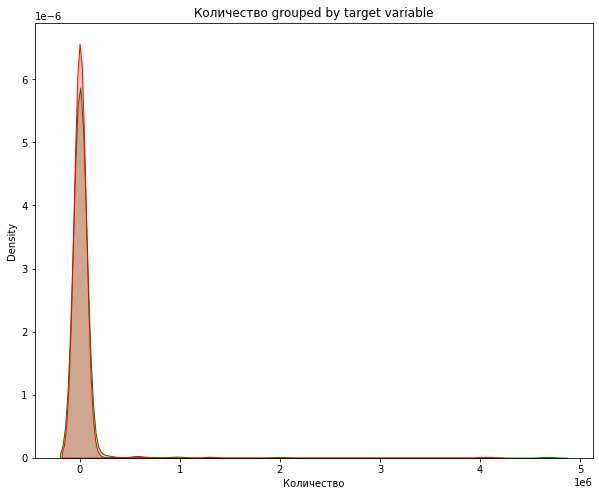

In [189]:
limit_bal_with_target_s = pr_df[['Количество', target_name]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Количество']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target_name] == 'buy']
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target_name] == 'sell']

plt.figure(figsize=(10, 8))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Количество')
plt.title('Количество grouped by target variable')
plt.show()

In [190]:
shapiro(limit_bal_s)

ShapiroResult(statistic=0.06522297859191895, pvalue=0.0)

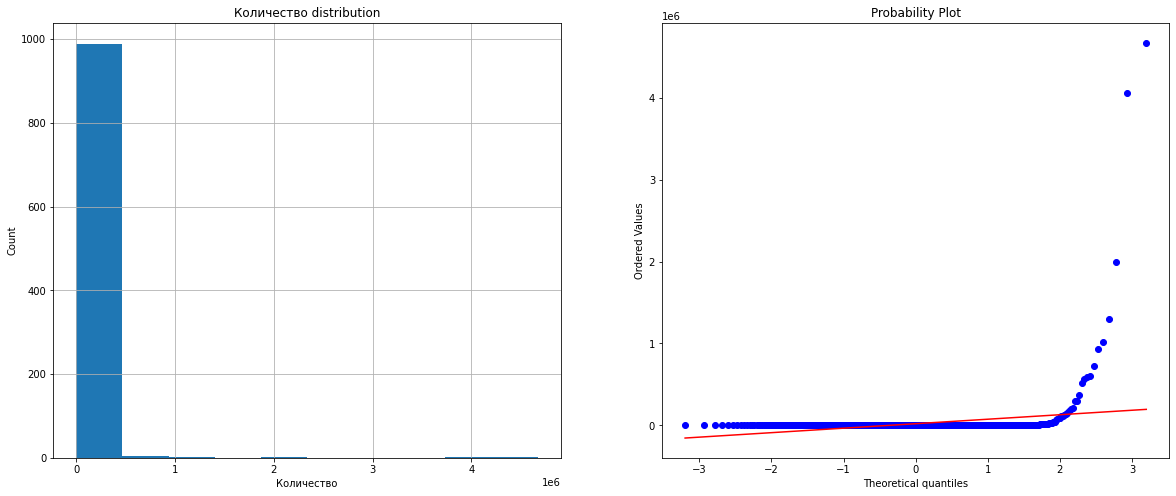

In [191]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Количество')
ax1.set_ylabel('Count')
ax1.set_title('Количество distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

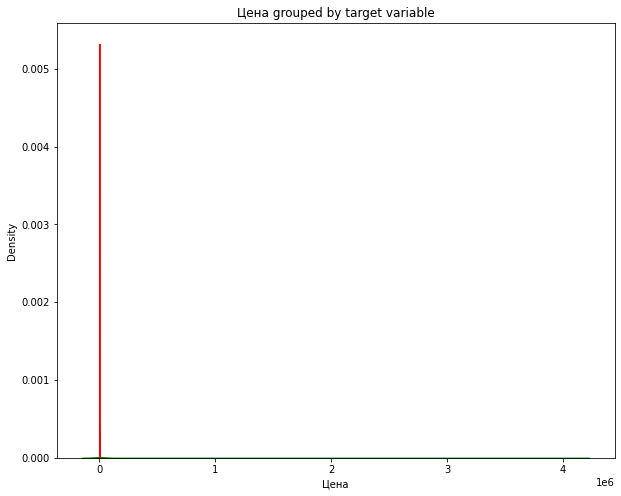

In [196]:
limit_bal_with_target_s = pr_df[['Цена', target_name]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Цена']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target_name] == 'buy']
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target_name] == 'sell']

plt.figure(figsize=(10, 8))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Цена')
plt.title('Цена grouped by target variable')
plt.show()

In [197]:
shapiro(limit_bal_s)

ShapiroResult(statistic=0.012062430381774902, pvalue=0.0)

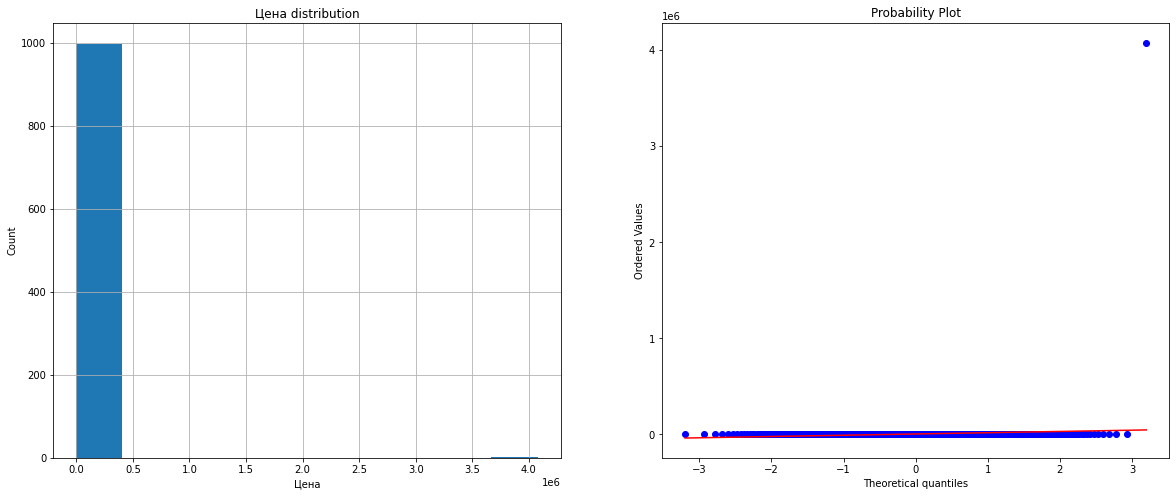

In [198]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Цена')
ax1.set_ylabel('Count')
ax1.set_title('Цена distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

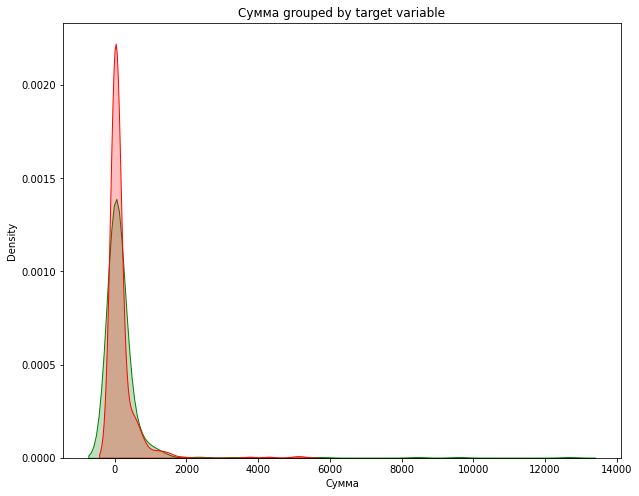

In [199]:
limit_bal_with_target_s = pr_df[['Сумма', target_name]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Сумма']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target_name] == 'buy']
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target_name] == 'sell']

plt.figure(figsize=(10, 8))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Сумма')
plt.title('Сумма grouped by target variable')
plt.show()

In [200]:
shapiro(limit_bal_s)

ShapiroResult(statistic=0.22853690385818481, pvalue=0.0)

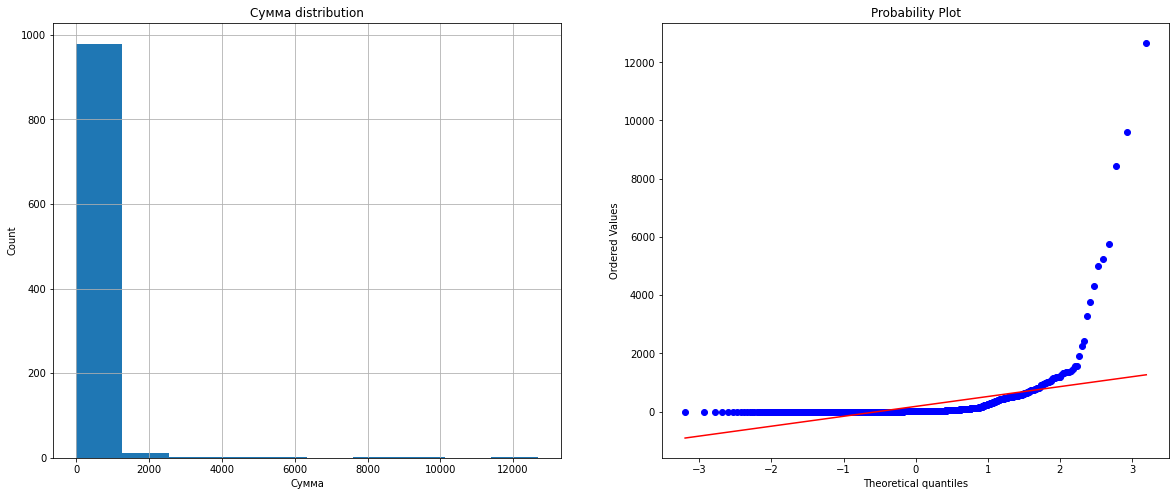

In [201]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Сумма')
ax1.set_ylabel('Count')
ax1.set_title('Сумма distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

### Наблюдение

Похоже что две группы, полученные в результате разбиения признака "Количество", "Цена", "Сумма"  по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Количество", "Цена", "Сумма"  и целевой переменной, возможно, существует некоторая функциональная зависимость.

##### Гипотеза

`Нулевая гипотеза:` средние значения в двух независимых выборках равны

`Альтернативная гипотеза:` средние значения в двух независимых выборках различаются

`Критерий:` критерий Стьюдента (t-тест) и его аналоги

`Уровень значимости  𝛼:` 0.05

`Критическая область:` двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

т.к критерий Стьюдента являтся параметрическим, то нам нужно проверить распределение признака на нормальность.

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

По гистограмме видно что сильно скошено и совсем не похоже на нормальное. И по графику квантиль-квантиль мы видим что график не лежит на прямой x-y. Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака LIMIT_BAL в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения, не является параметрическим.

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

### Обработка выбросов
IQR - interquantil Range

In [ ]:
plt.boxplot(df[''])
plt.title('Анализ выбросов для признака LIMIT_BAL ')

In [ ]:
import pandas as pd
from scipy import stats
import datetime
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
import datetime
import pprint
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Функция для вывода всех торговых пар, которые нашлись в истории торгов
# пары выводятся пронумированными
def enumirated_pairs(dataframe):
    all_pairs_list = dataframe['Валютная пара'].unique().tolist()
    print(f'\nОбщее число торговых пар в которых совершались сделки: {len(all_pairs_list)}')

# функция выводит сообщение о временном периоде проанализированных данных
# начало торгов - самая ранняя сделка в датафрейме
# конец торгов - самая последняя сделка в датафрейме
def time_period(dataframe):
    all_dates = dataframe['Дата/время'].tolist()
    start = all_dates[-1]
    end = all_dates[0]
    start_dtm = datetime.datetime.strptime(start, '%d.%m.%Y %H:%M')
    end_dtm = datetime.datetime.strptime(end, '%d.%m.%Y %H:%M')
    print(f'\nПроизведён анализ временного периода торговли: с {start} по {end}'
          f'\nчто составляет {end_dtm - start_dtm}')

# Объединение датасетов
def big_dataset(dataframe_first, dataframe_last):
    big_df = pd.concat([dataframe_first, dataframe_last], ignore_index=True)
    big_df_uniq = big_df.drop_duplicates()
    # что то сделать с индексами, т. к после дубликата их значения сбиваются
    return big_df_uniq

# Проверка при объединении датасетов на дубликаты
def duplicates(dataframe_first, dataframe_last):
    big_df = pd.concat([dataframe_first, dataframe_last], ignore_index=True).drop_duplicates()
    if len(big_df) == len(dataframe_first) + len(dataframe_last):
        print('Полное объединение датасетов. Дубликатов нет.\n'
              'Следует проверить последние и первые даты в датасетах\n'
              'возможно есть промежуточный датасет ')
    else:
        print('Объединение датасетов произошло. Число дубликатов:', len(dataframe_first) + len(dataframe_last) - len(big_df))


# Переформатирование типа колонки время в дататайм формат
def to_datetime(dataframe):
    dataframe['Дата/время'] = pd.to_datetime(dataframe['Дата/время'], format='%d.%m.%Y %H:%M')
    return dataframe

# Общее число сделок
# из них сделок BUY и SELL
def trades_count(dataframe):
    print(f'\nОбщее число сделок во всех торговых парах за проанализированный период времени: {len(dataframe)} из них')
    print('BUY сделки:', len(dataframe.loc[(dataframe['Тип'] == 'buy')]))
    print('SELL сделки:', len(dataframe.loc[(dataframe['Тип'] == 'sell')]))

def trades_count_pair(dataframe):
    print(f'\nОбщее число сделок в торговой паре за проанализированный период времени: {len(dataframe)} из них')
    print('BUY сделки:', len(dataframe.loc[(dataframe['Тип'] == 'buy')]))
    print('SELL сделки:', len(dataframe.loc[(dataframe['Тип'] == 'sell')]))

# Визуализация данных по Buy и Sell
def visual_buy_sell(dataframe):
    g = sns.countplot(dataframe['Тип'])
    g.set_xticklabels(['buy','sell'])
    plt.show()

# количество сделок в каждой торговой паре
def curr_pair_trade_counts(dataframe):
    print('Колличество сделок в каждой торговой паре:')
    print(dataframe['Валютная пара'].value_counts())

# Статистика

def moda(dataframe):
    print('\nМОДА')
    print('цена:', stats.mode(dataframe.Цена))  # scipy way
    print('Количество:', stats.mode(dataframe.Количество))  # scipy way
    print('Сумма:', stats.mode(dataframe.Сумма))

def median(dataframe):
    print('\nМЕДИАНА')
    print('цена:', dataframe.Цена.median())  # pandas way
    print('Количество:', dataframe.Количество.median())
    print('Сумма:', dataframe.Сумма.median())

def middle(dataframe):
    print('\nСРЕДНЕЕ')
    print('цена:', dataframe.Цена.mean())  # pandas way
    print('Количество:', dataframe.Количество.mean())
    print('Сумма:', dataframe.Сумма.mean())

def maxmin(dataframe):
    print('\nМАКСИМУМ')
    max = dataframe.Цена.max()
    print('цена:', max)  # pandas way
    print('\nМИНИМУМ')
    print('цена:', dataframe.Цена.min())  # pandas way

# аналитика торговли (применять к одной торговой паре)
def analitica(dataframe, current_pair):
    current_pair_dataset_buy = dataframe.loc[(current_pair_dataset['Тип'] == 'buy')]
    current_pair_dataset_sell = dataframe.loc[(current_pair_dataset['Тип'] == 'sell')]
    currents_list = currents(current_pair)
    print(f'\nминимальная цена по которой покупали: {current_pair_dataset_buy.Цена.min()} '
          f'{currents_list[1]}\n'
          f'максимальная цена по которой продавали: {current_pair_dataset_sell.Цена.max()} '
          f'{currents_list[1]}\n'
          f'oбъём купленной валюты за весь период торгов: {current_pair_dataset_buy.Количество.sum()} '
          f'{currents_list[0]}\n'
          f'oбъём проданной валюты за весь период торгов: {current_pair_dataset_sell.Количество.sum()} '
          f'{currents_list[0]}\n'
          f'потрачено денег за весь период торгов: {current_pair_dataset_buy.Сумма.sum()} '
          f'{currents_list[1]}\n'
          f'заработано денег за весь период торгов: {current_pair_dataset_sell.Сумма.sum()} '
          f'{currents_list[1]}\n\n'
          f'дельта максимальная цена - минимальная: {current_pair_dataset_sell.Цена.max() - current_pair_dataset_buy.Цена.min()} '
          f'{currents_list[1]}\n'
          f'разница объёмов проданный - купленный: {current_pair_dataset_sell.Количество.sum() - current_pair_dataset_buy.Количество.sum()} '
          f'{currents_list[0]}\n'
          f'коэфицент объёмов проданное/купленное: {round(current_pair_dataset_sell.Количество.sum()/current_pair_dataset_buy.Количество.sum(), 2)}\n'
          f'потраченныe деньги минус заработанные: {current_pair_dataset_sell.Сумма.sum() - current_pair_dataset_buy.Сумма.sum()} '
          f'{currents_list[1]}\n'
          f'коэфицент потраченные/заработанные: {round(current_pair_dataset_sell.Сумма.sum()/current_pair_dataset_buy.Сумма.sum(), 2)}\n')

def currents(current_pair):
    pair_list = current_pair.split('_')
    return pair_list

# Проверка на дисбаланс классов
def dissbalance(dataframe):
    # class count
    class_count_0, class_count_1 = dataframe['Тип'].value_counts()

    # Separate class
    class_0 = dataframe[dataframe['Тип'] == 'buy']
    class_1 = dataframe[dataframe['Тип'] == 'sell']# print the shape of the class
    print('buy class 0:', class_0.shape)
    print('sell class 1:', class_1.shape)

# Изменение начального датасета, добавление демипеременных, избавление от типов object
def prepare_data(dataframe):
    prep_data = pd.concat([dataframe, pd.get_dummies(dataframe['Тип'])], axis=1)
    prep_data.drop(columns=['Тип'], inplace=True)
    prep_data = pd.concat([prep_data, pd.get_dummies(dataframe['Тип комиссии'])], axis=1)
    prep_data.drop(columns=['Тип комиссии'], inplace=True)
    prep_data = pd.concat([prep_data, pd.get_dummies(dataframe['Комиссия %'])], axis=1)
    prep_data.drop(columns=['Комиссия %'], inplace=True)
    prep_data.drop(columns=['Trade ID'], inplace=True)
    prepare_data = to_datetime(prep_data)
    return prepare_data
    
# Число сделок в день
def per_day(dataframe):
    new_vals = []
    vals = dataframe['Дата/время'].values
    for el in vals:
        numb = el[0:2]
        new_vals.append(numb)
    dataframe['days'] = new_vals
    dataframe['days'].value_counts()
    return dataframe['days'].value_counts()

#######################################

# загружаю последнюю историю и самую раннюю скаченную историю торгов
df = pd.read_csv('trade-history-2023-04-23.csv')
df_first = pd.read_csv('trade-history-2021-11-07.csv')

df_all_dates = big_dataset(df, df_first)

duplicates(df, df_first)

# сортировка по годам
df_2021 = df_all_dates[df_all_dates['Дата/время'].str.contains("2021")]
df_2022 = df_all_dates[df_all_dates['Дата/время'].str.contains("2022")]
df_2023 = df_all_dates[df_all_dates['Дата/время'].str.contains("2023")]

# сортировка по месяцам
df_jan_2021 = df_2021[df_2021['Дата/время'].str.contains(".01.2021")]
df_feb_2021 = df_2021[df_2021['Дата/время'].str.contains(".02.2021")]
df_mar_2021 = df_2021[df_2021['Дата/время'].str.contains(".03.2021")]
df_apr_2021 = df_2021[df_2021['Дата/время'].str.contains(".04.2021")]
df_may_2021 = df_2021[df_2021['Дата/время'].str.contains(".05.2021")]
df_jun_2021 = df_2021[df_2021['Дата/время'].str.contains(".06.2021")]
df_jul_2021 = df_2021[df_2021['Дата/время'].str.contains(".07.2021")]
df_avg_2021 = df_2021[df_2021['Дата/время'].str.contains(".08.2021")]
df_sep_2021 = df_2021[df_2021['Дата/время'].str.contains(".09.2021")]
df_oct_2021 = df_2021[df_2021['Дата/время'].str.contains(".10.2021")]
df_nov_2021 = df_2021[df_2021['Дата/время'].str.contains(".11.2021")]
df_dec_2021 = df_2021[df_2021['Дата/время'].str.contains(".12.2021")]

df_jan_2022 = df_2022[df_2022['Дата/время'].str.contains(".01.2022")]
df_feb_2022 = df_2022[df_2022['Дата/время'].str.contains(".02.2022")]
df_mar_2022 = df_2022[df_2022['Дата/время'].str.contains(".03.2022")]
df_apr_2022 = df_2022[df_2022['Дата/время'].str.contains(".04.2022")]
df_may_2022 = df_2022[df_2022['Дата/время'].str.contains(".05.2022")]
df_jun_2022 = df_2022[df_2022['Дата/время'].str.contains(".06.2022")]
df_jul_2022 = df_2022[df_2022['Дата/время'].str.contains(".07.2022")]
df_avg_2022 = df_2022[df_2022['Дата/время'].str.contains(".08.2022")]
df_sep_2022 = df_2022[df_2022['Дата/время'].str.contains(".09.2022")]
df_oct_2022 = df_2022[df_2022['Дата/время'].str.contains(".10.2022")]
df_nov_2022 = df_2022[df_2022['Дата/время'].str.contains(".11.2022")]
df_dec_2022 = df_2022[df_2022['Дата/время'].str.contains(".12.2022")]

df_jan_2023 = df_2023[df_2023['Дата/время'].str.contains(".01.2023")]
df_feb_2023 = df_2023[df_2023['Дата/время'].str.contains(".02.2023")]
df_mar_2023 = df_2023[df_2023['Дата/время'].str.contains(".03.2023")]
df_apr_2023 = df_2023[df_2023['Дата/время'].str.contains(".04.2023")]
df_may_2023 = df_2023[df_2023['Дата/время'].str.contains(".05.2023")]
df_jun_2023 = df_2023[df_2023['Дата/время'].str.contains(".06.2023")]
df_jul_2023 = df_2023[df_2023['Дата/время'].str.contains(".07.2023")]
df_avg_2023 = df_2023[df_2023['Дата/время'].str.contains(".08.2023")]
df_sep_2023 = df_2023[df_2023['Дата/время'].str.contains(".09.2023")]
df_oct_2023 = df_2023[df_2023['Дата/время'].str.contains(".10.2023")]
df_nov_2023 = df_2021[df_2021['Дата/время'].str.contains(".11.2023")]
df_dec_2023 = df_2023[df_2023['Дата/время'].str.contains(".12.2023")]


# time_period(df_all_dates)
# trades_count(df_all_dates)
# enumirated_pairs(df_all_dates)
# curr_pair_trade_counts(df_all_dates)

time_period(df_all_dates)
trades_count(df_all_dates)
enumirated_pairs(df_all_dates)
curr_pair_trade_counts(df_all_dates)


print(f'\nСделки за 2021 год. Общее количество: {len(df_2021)}'
      f'\nЯнварь 2021: {len(df_jan_2021)}'
      f'\nФевраль 2021: {len(df_feb_2021)}'
      f'\nМарт 2021: {len(df_mar_2021)}'
      f'\nАпрель 2021: {len(df_apr_2021)}'
      f'\nМай 2021: {len(df_may_2021)}'
      f'\nИюнь 2021: {len(df_jun_2021)}'
      f'\nИюль 2021: {len(df_jul_2021)}'
      f'\nАвгуст 2021: {len(df_avg_2021)}'
      f'\nСентябрь 2021: {len(df_sep_2021)}'
      f'\nОктябрь 2021: {len(df_oct_2021)}'
      f'\nНоябрь 2021: {len(df_nov_2021)}'
      f'\nДекабрь 2021: {len(df_dec_2021)}')

print(f'\nСделки за 2022 год. Общее количество: {len(df_2022)}'
      f'\nЯнварь 2022: {len(df_jan_2022)}'
      f'\nФевраль 2022: {len(df_feb_2022)}'
      f'\nМарт 2022: {len(df_mar_2022)}'
      f'\nАпрель 2022: {len(df_apr_2022)}'
      f'\nМай 2022: {len(df_may_2022)}'
      f'\nИюнь 2022: {len(df_jun_2022)}'
      f'\nИюль 2022: {len(df_jul_2022)}'
      f'\nАвгуст 2022: {len(df_avg_2022)}'
      f'\nСентябрь 2022: {len(df_sep_2022)}'
      f'\nОктябрь 2022: {len(df_oct_2022)}'
      f'\nНоябрь 2022: {len(df_nov_2022)}'
      f'\nДекабрь 2022: {len(df_dec_2022)}')

print(f'\nСделки за 2023 год. Общее количество: {len(df_2023)}'
      f'\nЯнварь 2023: {len(df_jan_2023)}'
      f'\nФевраль 2023: {len(df_feb_2023)}'
      f'\nМарт 2023: {len(df_mar_2023)}'
      f'\nАпрель 2023: {len(df_apr_2023)}'
      f'\nМай 2023: {len(df_may_2023)}'
      f'\nИюнь 2023: {len(df_jun_2023)}'
      f'\nИюль 2023: {len(df_jul_2023)}'
      f'\nАвгуст 2023: {len(df_avg_2023)}'
      f'\nСентябрь 2023: {len(df_sep_2023)}'
      f'\nОктябрь 2023: {len(df_oct_2023)}'
      f'\nНоябрь 2023: {len(df_nov_2023)}'
      f'\nДекабрь 2023: {len(df_dec_2023)}')

current_pair = input('\nВведите/выбирете название торговой пары для которой будет произведён анализ: ')
print(50 * '_')

# сортировка по имени торговой пары
current_pair_dataset = df_all_dates.loc[(df_all_dates['Валютная пара'] == current_pair)]

time_period(current_pair_dataset)
trades_count_pair(current_pair_dataset)
analitica(current_pair_dataset, current_pair)
moda(current_pair_dataset)
maxmin(current_pair_dataset)
middle(current_pair_dataset)
median(current_pair_dataset)

#####################################
time_period(df_2023)
trades_count(df_2023)
enumirated_pairs(df_2023)
curr_pair_trade_counts(df_2023)
current_pair = input('\nВведите/выбирете название торговой пары для которой будет произведён анализ: ')
print(50 * '_')
current_pair_dataset = df_all_dates.loc[(df_all_dates['Валютная пара'] == current_pair)]
time_period(current_pair_dataset)
trades_count_pair(current_pair_dataset)
analitica(current_pair_dataset, current_pair)
moda(current_pair_dataset)
maxmin(current_pair_dataset)
middle(current_pair_dataset)
median(current_pair_dataset)
########################################

Полное объединение датасетов. Дубликатов нет.
Следует проверить последние и первые даты в датасетах
возможно есть промежуточный датасет 

Произведён анализ временного периода торговли: с 14.04.2021 06:57 по 23.04.2023 16:15
что составляет 739 days, 9:18:00

Общее число сделок во всех торговых парах за проанализированный период времени: 19769 из них
BUY сделки: 10570
SELL сделки: 9199

Общее число торговых пар в которых совершались сделки: 62
Колличество сделок в каждой торговой паре:
EXM_RUB      2430
USDT_GBP     2104
WXT_USDT     1428
SMART_EUR    1254
EXM_BTC      1208
             ... 
ALGO_BTC        1
BTC_USDX        1
VITAE_BTC       1
ONT_BTC         1
BTC_RUB         1
Name: Валютная пара, Length: 62, dtype: int64

Сделки за 2021 год. Общее количество: 11822
Январь 2021: 0
Февраль 2021: 0
Март 2021: 0
Апрель 2021: 1257
Май 2021: 1217
Июнь 2021: 2345
Июль 2021: 1283
Август 2021: 1391
Сентябрь 2021: 945
Октябрь 2021: 1148
Ноябрь 2021: 929
Декабрь 2021: 1307

Сделки за 2022 год. 

In [45]:
columns = list(big_df.columns)
columns

['Дата/время',
 'Trade ID',
 'Тип',
 'Валютная пара',
 'Количество',
 'Цена',
 'Сумма',
 'Тип комиссии',
 'Размер комиссии',
 'Комиссия %']

Text(0.5, 1.0, 'Анализ выбросов для признака Сумма')

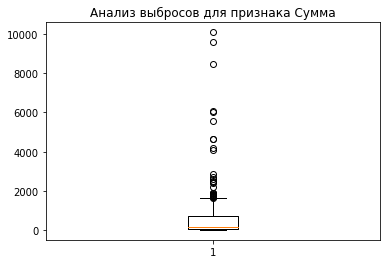

In [54]:
plt.boxplot(df_cur_pair['Сумма'])
plt.title('Анализ выбросов для признака Сумма')

Text(0.5, 1.0, 'Анализ выбросов для признака Количество')

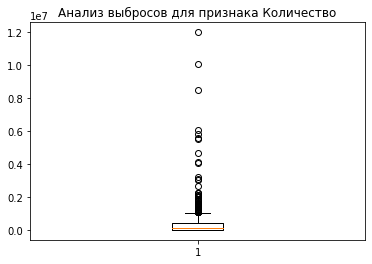

In [53]:
plt.boxplot(df_cur_pair['Количество'])
plt.title('Анализ выбросов для признака Количество')

Text(0.5, 1.0, 'Анализ выбросов для признака Дата/время')

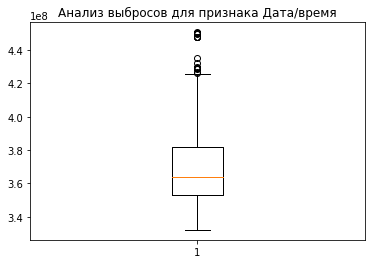

In [52]:
plt.boxplot(df_cur_pair['Trade ID'])
plt.title('Анализ выбросов для признака Trade ID')

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

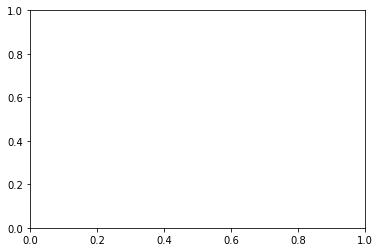

In [50]:
for el in columns:
    plt.boxplot(df_cur_pair[el])
    plt.title(f'Анализ выбросов для признака Дата\')

Text(0.5, 1.0, 'Анализ выбросов для признака Цена ')

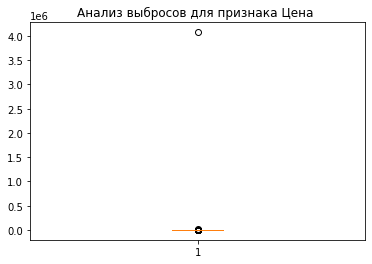

In [48]:
plt.boxplot(big_df['Цена'])
plt.title('Анализ выбросов для признака Цена ')

Text(0.5, 1.0, 'Анализ выбросов для признака Цена ')

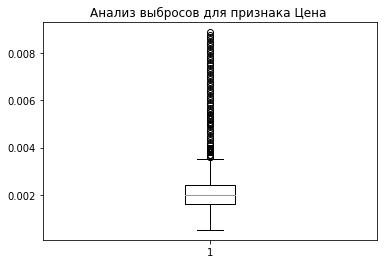

In [49]:
plt.boxplot(df_cur_pair['Цена'])
plt.title('Анализ выбросов для признака Цена ')

### Вывод квантилей для одного свойства

In [56]:
df_cur_pair['Цена'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

0.10    0.0009
0.25    0.0016
0.50    0.0020
0.75    0.0024
0.90    0.0038
Name: Цена, dtype: float64

### Построение новых признаков

In [59]:
df_cur_pair['ID'] = df_cur_pair.index.tolist()

AttributeError: 'Int64Index' object has no attribute 'range'

In [58]:
df_cur_pair

,Дата/время,Trade ID,Тип,Валютная пара,Количество,Цена,Сумма,Тип комиссии,Размер комиссии,Комиссия %,days,ID
149,20.01.2023 20:16,450506353,sell,SHIB_RUB,4.341111e+05,0.0009,390.699981,maker,1.172100,0.3%,20,149
158,19.01.2023 17:00,450227083,sell,SHIB_RUB,2.157764e+04,0.0009,19.419872,maker,0.058260,0.3%,19,158
159,19.01.2023 16:57,450226559,sell,SHIB_RUB,9.443113e+05,0.0009,849.880147,maker,2.549640,0.3%,19,159
177,19.01.2023 05:49,450111989,buy,SHIB_RUB,1.442148e+06,0.0008,1153.718776,maker,4326.445411,0.3%,19,177
209,18.01.2023 11:42,449917856,sell,SHIB_RUB,1.433444e+04,0.0009,12.900997,maker,0.038703,0.3%,18,209
...,...,...,...,...,...,...,...,...,...,...,...,...
9085,18.11.2021 15:04,332211289,buy,SHIB_RUB,1.250000e+05,0.0040,500.000000,maker,0.000000,0%,18,9085
9086,18.11.2021 15:04,332211281,buy,SHIB_RUB,1.423875e+05,0.0052,740.414903,taker,0.000000,0%,18,9086
9087,18.11.2021 15:04,332211280,buy,SHIB_RUB,1.085462e+05,0.0050,542.730899,taker,0.000000,0%,18,9087
9088,18.11.2021 15:04,332211256,buy,SHIB_RUB,1.114358e+04,0.0050,55.717912,maker,0.000000,0%,18,9088
